***
# <center> Flower Images Classification using CNN</center>
***
## Introduction :
The aim of this project is to try to build a flower classification model that can classify flower images into 102 categories, the data used to train the models is _the 102-flowers dataset_

To accomplish this task, we'll try at first to import our data, do some preprocessing to it, and then build and train our models (we'll use a simple model at first as a reference, then we'll apply some _<b>transfer learning</b>_ by re-using some well known model's layers).

Let's start by uploading our data :

## 1.Data importation :

In [ ]:
# Libraries importation
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf
import pathlib

import os
from functools import partial

from tensorflow import keras

NOTE : The next block is used once to restructure the data into a file tree, each of its branch is a flower class. this restructuration will help us on the data importation (since somehow the keras <code>image_dataset_from_directory</code> doesn't work correctly when given classes as a list (an existent bug)).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data importation & splitting :
## used parameters
batch_size = 32
image_size = (256,256) # Size cho mô hình Basic CNN

## Chỉ định đường dẫn tới 3 thư mục của bạn
base_dir = pathlib.Path('/content/drive/MyDrive/Colab_Notebooks/102 flower/flowers')
train_dir = base_dir / 'train'
valid_dir = base_dir / 'valid'
test_dir = base_dir / 'test'

## Train DataSet (Tải từ /train)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
                train_dir,
                labels='inferred',
                label_mode='int',
                color_mode='rgb',
                batch_size=batch_size,
                image_size=image_size,
                shuffle=True,
                seed=123,
                interpolation='bilinear'
            )

## Validation DataSet (Tải từ /valid)
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
                valid_dir,
                labels='inferred',
                label_mode='int',
                color_mode='rgb',
                batch_size=batch_size,
                image_size=image_size,
                shuffle=False,
                seed=123,
                interpolation='bilinear'
            )

## Test Dataset (Tải từ /test)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
                test_dir,
                labels='inferred',
                label_mode='int',
                color_mode='rgb',
                batch_size=batch_size,
                image_size=image_size,
                shuffle=False,
                seed=123,
                interpolation='bilinear'
            )

## Class names & number (Sửa lại để tự động đếm)
class_names = train_data.class_names
num_classes = len(class_names)

print(f"=========================================================")
print(f"Đã tìm thấy {num_classes} loài hoa (classes).")
print(f"=========================================================")

Found 6552 files belonging to 102 classes.
Found 818 files belonging to 102 classes.
Found 819 files belonging to 102 classes.
Đã tìm thấy 102 loài hoa (classes).


In [ ]:
import json

with open("model_classes.json", "w") as f:
    json.dump(class_names, f)

print("Đã tạo file model_classes.json! Hãy tải nó về.")

Đã tạo file model_classes.json! Hãy tải nó về.


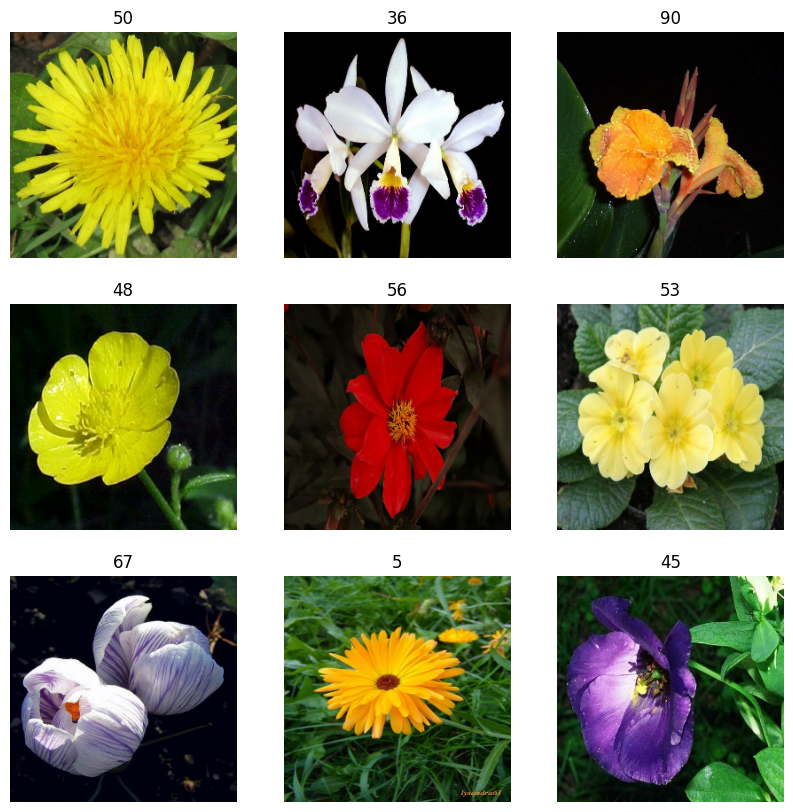

In [ ]:
# Plotting the first pictures on the first batch (A simple verification)
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        i+=1
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 2.Basic model implementation :
### i.Model structure :
- First we use a preprocessing layer to rescale our images to a $[0, 1]$ shape.
- Next we use three convolutional layers, each followed by a MaxPooling layer to downsample our inputs and then get the most important features from each previous layer.
- Next is the fully connected network, composed of one hidden dense layer and a
dense output layer. We did use a flatten array since the dense layers expect a 1D array. And since it is a classification problem, we use the softmax activation function on the last layer.

In [ ]:
# Fist model (A Basic CNN):
## Model structure :
basic_model = tf.keras.Sequential([
    keras.layers.Rescaling(1./255),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes, activation="softmax")
])

### ii.Compilation & fitting parameters :

For the model compilation, we use the <b>ADAM</b> optimiser to avoid the 'exploding gradient'/'The vanishing gradient' problems, and a <b>sparse cateorical crossentropy loss</b> since we are dealing with a multi-classification problem, and finally an accuracy metric to evaluate our model's performance throughout the learning-validation process :

In [ ]:
## Model compilation :
basic_model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

To Regularise more our model, and avoid any possible overfitting, we'll use the <b>early-stopping</b> method :

In [ ]:
## Early stopping CallBack :
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
    restore_best_weights=True)

## Fitting the data :
basic_model.fit(train_data,
    validation_data=valid_data,
    callbacks=[early_stopping_cb],
    epochs=20)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


205/205 ━━━━━━━━━━━━━━━━━━━━ 1236s 6s/step - accuracy: 0.0579 - loss: 4.3773 - val_accuracy: 0.1736 - val_loss: 3.3468
Epoch 2/20
118/205 ━━━━━━━━━━━━━━━━━━━━ 3:54 3s/step - accuracy: 0.2303 - loss: 3.1415

KeyboardInterrupt: 

### iii.Model evaluation & conclusion :
Obviously our model didn't perform well due to :
- its simplicity : not deep enough to capture all the data features
- the lack of data to be able to augment the number of filters and then capture more features.

And even by overcoming the two reasons before, another reason may occure, which is related to the RAM and the learning time, the convolutional layers require a huge amount of RAM during training, because the reverse pass of backpropagation
requires all the intermediate values computed during the forward pass. Due to that, the learning time will be huge (if we want to build a decent (deep enough) model to capture all the data features).

Gladly, we can use some already pretrained layers from other models that treat almost the same task (image classification) by applying a transfer learning, the next models will use this method to try to minimise the learing time, exploit already built and trained (and famous) model layers, and maybe reach a much higher performance by using only the small amoount of data we have :

## 3. Transfer learning & hybrid models :
In this part we'll use some already existent models to build our classification model, and do a benchmark at the end to choose the best suited model based on a performance comparison.

The methodology that we'll follow for each model is the following :
- First, we run the data through a data augmentation (that also plays a regulation role) & preprocessing pipeline (customised for each base model, since each one requires a special input shape)
- Next we create a custom model by using all the base model's layers except the output layer, and by adding our own output layers.
- Next we freeze our base model's layers and train the model on a small number of epochs (to help the new layers catch up, and also to not ruin the pretrained base layers)
- Finally we unfreeze some of the frozen layers, train our model (by using the early stopping method to avoid overfitting) and evaluate the model on the test data.

In [ ]:
# Custom Data preprocessing (Different for each model):
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop

    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100

    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, model, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)

    resized_image = tf.image.resize(cropped_image, [224, 224])
    if model =="ResNet":
        final_image = keras.applications.resnet.preprocess_input(resized_image)
    elif model == "Xception":
        final_image = keras.applications.xception.preprocess_input(resized_image)
    elif model == "Inception":
        final_image = keras.applications.inception_v3.preprocess_input(resized_image)

    return final_image, label


### i.ResNet :

In [ ]:
# Tự động tính toán steps
steps_per_epoch = len(train_data)
validation_steps = len(valid_data)

## Preprocessed data
train_data_rn = train_data.unbatch().map(partial(preprocess, model="ResNet", randomize=True)).batch(batch_size).prefetch(1)
val_data_rn = valid_data.unbatch().map(partial(preprocess, model="ResNet")).batch(batch_size).prefetch(1)
test_data_rn = test_data.unbatch().map(partial(preprocess, model="ResNet")).batch(batch_size).prefetch(1)

In [ ]:
# Prepare the base model :
base_model_rn = keras.applications.ResNet50(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model_rn.output)
output = keras.layers.Dense(num_classes, activation="softmax")(avg)
model_rn = keras.models.Model(inputs=base_model_rn.input, outputs=output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Freezing the base model layers :
for layer in base_model_rn.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)
model_rn.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model_rn.fit(train_data_rn,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_data_rn,
                    validation_steps=validation_steps,
                    epochs=5)

In [ ]:
# Unfreezing the last base model layers :
num_layers = len(base_model_rn.layers)
for layer in base_model_rn.layers[num_layers-6:]:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
## Early stopping CallBack :
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
    restore_best_weights=True)

## Model compilation :
model_rn.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

## Model training :
history = model_rn.fit(train_data_rn,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_data_rn,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping_cb],
                    epochs=5)

In [ ]:
# Model evaluation :
print("--- Đánh giá mô hình ResNet trên tập Test ---")
model_rn.evaluate(test_data_rn)

### ii.Xception :

In [ ]:
# Tự động tính toán steps (Nếu chạy cell này riêng thì cần)
steps_per_epoch = len(train_data)
validation_steps = len(valid_data)

## Preprocessed data
train_data_xcp = train_data.unbatch().map(partial(preprocess, model="Xception",randomize=True)).batch(batch_size).prefetch(1)
val_data_xcp = valid_data.unbatch().map(partial(preprocess, model="Xception")).batch(batch_size).prefetch(1)
test_data_xcp = test_data.unbatch().map(partial(preprocess, model="Xception")).batch(batch_size).prefetch(1)

In [ ]:
# Prepare the base model :
base_model_xcp = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model_xcp.output)
output = keras.layers.Dense(num_classes, activation="softmax")(avg)
model_xcp = keras.models.Model(inputs=base_model_xcp.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Freezing the base model layers :
for layer in base_model_xcp.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)
model_xcp.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model_xcp.fit(train_data_xcp.repeat(),
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_data_xcp.repeat(),
                    validation_steps=validation_steps,
                    epochs=5)

Epoch 1/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1663s 8s/step - accuracy: 0.8546 - loss: 0.6257 - val_accuracy: 0.6822 - val_loss: 2.2465
Epoch 2/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1624s 8s/step - accuracy: 0.8617 - loss: 0.7019 - val_accuracy: 0.8166 - val_loss: 0.9378
Epoch 3/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1590s 8s/step - accuracy: 0.9064 - loss: 0.3501 - val_accuracy: 0.7958 - val_loss: 1.2379
Epoch 4/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1589s 8s/step - accuracy: 0.9141 - loss: 0.3367 - val_accuracy: 0.8240 - val_loss: 0.9574
Epoch 5/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1595s 8s/step - accuracy: 0.9230 - loss: 0.2939 - val_accuracy: 0.8484 - val_loss: 0.8749


In [ ]:
# Unfreezing the last base model layers :
num_layers = len(base_model_xcp.layers)
for layer in base_model_xcp.layers[num_layers-6:]:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True)
## Early stopping CallBack :
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
    restore_best_weights=True)

## Model compilation :
model_xcp.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

## Model training :
history = model_xcp.fit(train_data_xcp.repeat(),
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_data_xcp.repeat(),
                    validation_steps=validation_steps,
                    callbacks=[early_stopping_cb],
                    epochs=4)

Epoch 1/4
205/205 ━━━━━━━━━━━━━━━━━━━━ 1897s 9s/step - accuracy: 0.9222 - loss: 0.2871 - val_accuracy: 0.8826 - val_loss: 0.6297
Epoch 2/4
205/205 ━━━━━━━━━━━━━━━━━━━━ 1877s 9s/step - accuracy: 0.9811 - loss: 0.0679 - val_accuracy: 0.8973 - val_loss: 0.4633
Epoch 3/4
205/205 ━━━━━━━━━━━━━━━━━━━━ 1943s 9s/step - accuracy: 0.9889 - loss: 0.0363 - val_accuracy: 0.8888 - val_loss: 0.5076
Epoch 4/4
205/205 ━━━━━━━━━━━━━━━━━━━━ 1906s 9s/step - accuracy: 0.9910 - loss: 0.0295 - val_accuracy: 0.9108 - val_loss: 0.4603


In [ ]:
print("--- Đánh giá mô hình Xception trên tập Test ---")
model_xcp.evaluate(test_data_xcp)

--- Đánh giá mô hình Xception trên tập Test ---
26/26 ━━━━━━━━━━━━━━━━━━━━ 172s 7s/step - accuracy: 0.8756 - loss: 0.5141


[0.4877240061759949, 0.8840048909187317]

In [ ]:
print("=========================================================")
print("Đang lưu mô hình Xception (model_xcp)...")

model_xcp.save("flower_model.h5")

print("Đã lưu file 'flower_model.h5' thành công!")
print("Bạn có thể tải nó về từ cây thư mục bên trái.")
print("=========================================================")

Đang lưu mô hình Xception (model_xcp)...
Đã lưu file 'flower_model.h5' thành công!
Bạn có thể tải nó về từ cây thư mục bên trái.
